## Name: Shyam Sunder
## Roll N0. PH220C47

## Part 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
#generating totally uncorelated ranodm data to start
N = 2000 #number of data points
x = np.random.normal(0, 3, size=(N))
y = np.random.normal(0, 3, size=(N))

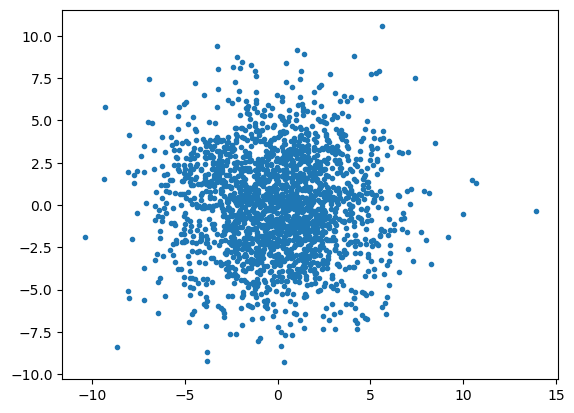

In [4]:
plt.plot(x,y, '.')

In [5]:
#coreating them with SVD matrices
c = 2 #corelation factor
corelation_matrix = np.identity(N)*c #the desries coreation matrix
# corelation_matrix = np.diag()

In [6]:
#doing the SVD Dempostions
U, s, V = svd(corelation_matrix)

In [7]:
#here s matrix is the eigen value columns only making eh S matrix from that 
S= np.diag(np.sqrt(s))

In [8]:
#making the corealtion making matrix
C = V@S

In [9]:
#making the corealted samples
y = C@x

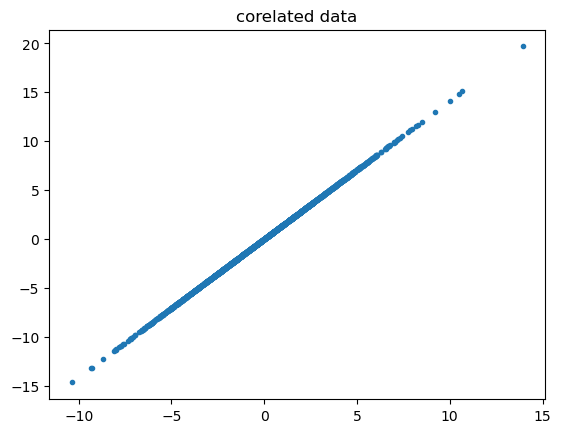

In [10]:
plt.plot(x, y, '.')
plt.title('corelated data')
plt.show()

Now that is perfectly corealated data, we can add more noice and make them less corelated

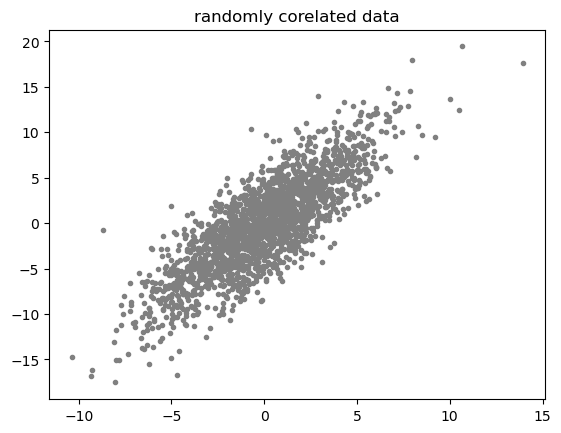

In [11]:
noise_amplitude = 3# a parameter to vary noise 
noise = noise_amplitude *  np.random.normal( size=(N)) #adding noise to corelated data
noised_y = y + noise #the noised data
plt.plot(x, noised_y, '. ', color='gray')
plt.title('randomly corelated data')
plt.show()

## PART 2

We gave given an eigen value equation, and we have given some data. Now we need to find out this data refers to which mode of eigen value equation. 

We have the equations as:
$$y''(x) +  \lambda y(x) = 0$$

With boundary condittions as:


$$y(0) + y'(0) = -a$$
$$y(\pi) + y'(\pi) =  b$$

We will use sympy for first solve for the equation and then we will do some curve fitting for fit the experiemental data and finding out the answers

In [12]:
import sympy

#defining the symbols in the diffrential equations
x, a,b,lambda_ = sympy.symbols('x a b lambda')
y = sympy.Function('y')(x)

#writing the diffrential equation
eq = sympy.Eq(y.diff(x, 2) + lambda_**2*y, 0)

#writing the boundary conditions
bc1 = sympy.Eq(y.subs(x, 0) + y.diff(x).subs(x, 0), -a)
bc2 = sympy.Eq(y.subs(x, sympy.pi) + y.diff(x).subs(x, sympy.pi), b)

#solving the equation
sol = sympy.dsolve(eq, y)
C1, C2 = sympy.symbols('C1 C2')
constants = sympy.solve([bc1, bc2], [C1, C2])
sol = sol.subs(constants)

print(sol)


Eq(y(x), C1*exp(-I*lambda*x) + C2*exp(I*lambda*x))


sumpy returns the solutions as:

$$y(x) = c1 \exp(-x -\sqrt{\lambda}) + c2 \exp(x \sqrt{-\lambda})$$

assuming $\lambda>0$ this can also be written as 

$$y(x) =  c1 \sin(x \sqrt{\lambda}) + c2 \cos(x \sqrt{\lambda})$$

We will use the data for fit it and find the values of the constants c1, c2 and $\lambda$

Note from now on I have used the diffrential equation as 

$$y''(x) +  \lambda^2 y(x) = 0$$

because it is easy to write lambda rather than `np.sqrt(lambda)`. 

And the solutions are accordingly. We can root the value after we find through fitting

In [13]:
data = pd.read_csv('Input.csv')

In [14]:
data['y'] = np.arange(0, np.pi+np.pi/60, np.pi/60)
data.head()

,x,y
0,1.766761,0.00000
1,1.073379,0.05236
2,0.881797,0.10472
3,0.554756,0.15708
4,0.158935,0.20944


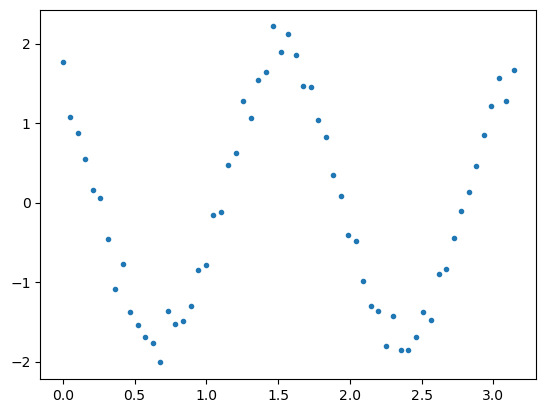

In [15]:
xs = data['y']
ys = data['x']
plt.plot(xs, ys, '.')
plt.show()

In [16]:
#the  solution given my sym
def y(x, c1,c2, lm):
    return c1*np.sin(lm*x) + c2*np.cos(lm*x)

In [17]:
#finding the value of constants by non-linear fit
para, var = curve_fit(y, xs, ys, p0=([0.2,  0.3,  1.]))

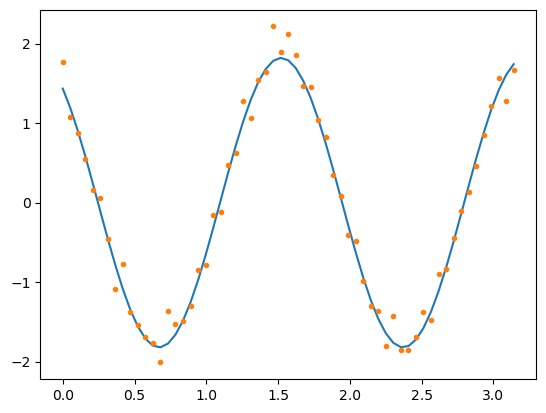

In [18]:
plt.plot(xs, y(xs,*para))
plt.plot(xs, ys, '.')
plt.show()

In [19]:
para[2]
lamda = np.sqrt(para[2])
print(lamda)

1.9220551758291862


This give us the value of $\lambda = 2$. This is the second mode. Onto calculating the cofficients

$$y(0) + y'(0) = -a$$
$$y(\pi) + y'(\pi) =  b$$


In [20]:
def y_prime(x, c1,c2,lam):
    return lam*(c1*np.cos(lam*x) - c2*np.sin(lam*x))

In [21]:
a =  - 1 *(y(0, *para) + y_prime(0,*para))
b = y(np.pi, *para) + y_prime(np.pi, *para)
print('a: ', a)
print('b: ',b)

a:  2.713546044861527
b:  3.706875902716876


putting that in and solving neumerically:

We have the equations as:
$$y''(x) +  \lambda y(x) = 0$$

With boundary condittions as:


$$y(0) + y'(0) = -a$$
$$y(\pi) + y'(\pi) =  b$$

In finite difference method, we can write these as:

$$\frac{y_{i+1}  + y_{i-1} -2y_i  }{h^2}  = - \lambda y _i$$
or

$$\frac{1}{h^2} y_{i+1} + \frac{1}{h^2}y_{i-1} - \left(\lambda -\frac{2}{h^2}  \right)y_i = 0$$

and the boundary conditions:
$$(1-\frac{1}{h})y_0 + \frac{1}{h} y_1 = 0$$
$$(1+\frac{1}{h})y_n - \frac{1}{h} y_{n-1} = 0$$


In [22]:
#defining the derac delta function
delta = lambda i,j: 1 if i==j else 0

#the time step
# h = np.pi/60
        
h = 1e-3
#defining the constatns

#the range of space
x0 = 0
xf = np.pi

def solution(lam, a, b):
        #building the sparse matrix

        N  = int((xf-x0)/h)+1#total number of steps
        mat = np.zeros((N, N), dtype='float64')

        #building the matrix
        for i in range(N):
            for j in range(N):
                mat[i,j] = delta(i-1, j)*(1/h**2) + delta(i+1, j) * (1/h**2) + delta(i,j)*(lamda - 2/(h**2))

        #setting up the boundary conditions
        mat[0,0] = (1-1/h)
        mat[0,1] = 1/h
        mat[-1,-1] = 1+1/h
        mat[-1,-2] = -1/h

        #setting up the cofficient matrix
        coff = np.zeros(N)
        coff[0] =  -a
        coff[-1] = b


        #the solution
        sol = np.linalg.inv(mat) @ coff
        return sol

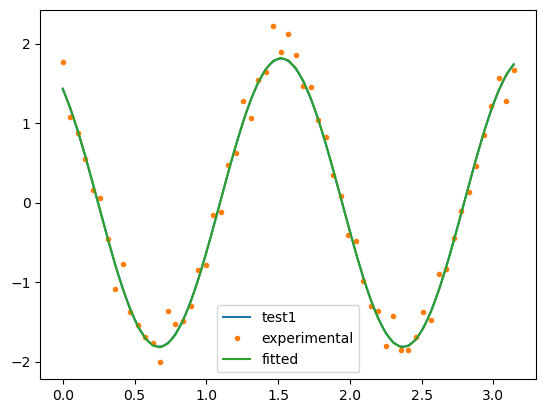

In [23]:
lamda = para[2]**2
a = a
b = b

test1 = solution(lamda, a, b)

plt.plot(np.arange(x0, xf, h) ,test1, label='test1')
plt.plot(xs, ys, '.', label='experimental')
plt.plot(xs, y(xs, *para), label='fitted')
plt.legend()
plt.show()

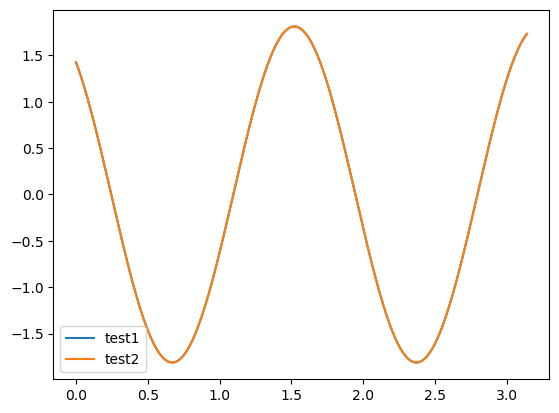

In [24]:
const = 1.0011e-15

lamda -= const
a = a-const
b = b-const

test2 = solution(lamda, a, b)
plt.plot(np.arange(x0, xf, h) ,test1, label='test1')
plt.plot(np.arange(x0, xf, h) ,test2, label='test2')
plt.legend()
plt.show()

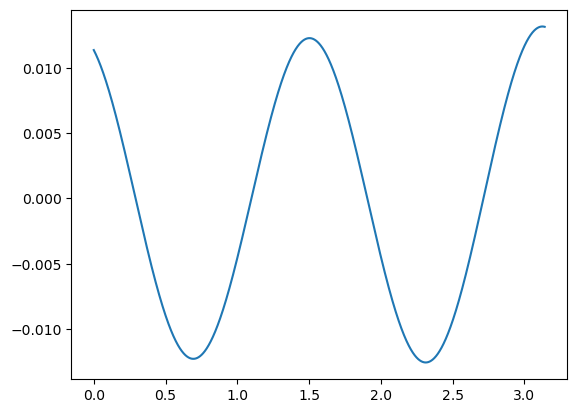

In [28]:
diff = test1-test2

#plotting the difference between these two
plt.plot(np.arange(x0, xf, h) ,diff,  label='test1')
plt.show()


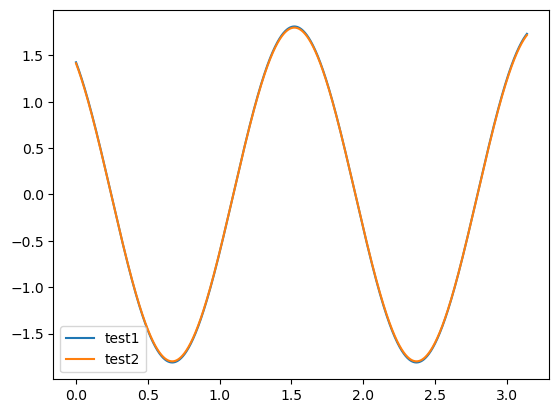

In [26]:
const = 1.0011e-2

lamda -= const
a = a-const
b = b-const

test2 = solution(lamda, a, b)
plt.plot(np.arange(x0, xf, h) ,test1, label='test1')
plt.plot(np.arange(x0, xf, h) ,test2, label='test2')
plt.legend()
plt.show()

plotting the difference between those two

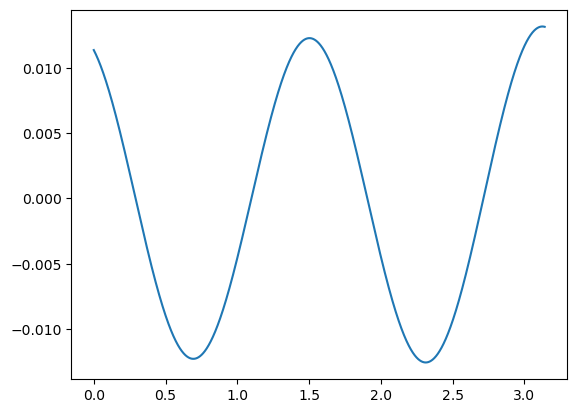

In [27]:
diff = test1-test2

plt.plot(np.arange(x0, xf, h) ,diff,  label='test1')
plt.show()

## Comments on the solution

This shows that that the simple harmonic oscillator is not so sansitive to the intial conditions. For some chaotic systems, slight changes in the intital conditions can cause big changes in outsome but that's not the case for simple harmonic, it the diff remains almost zeros for the most time. 